In [1]:
# coding=utf-8
import os
import math
import time
import joblib
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from xgboost import *
from scipy.stats import normaltest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.datasets import load_digits, make_hastie_10_2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# %matplotlib
# %matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 2000)

In [2]:
df = pd.read_csv('./data/noisy_data.csv')
df

,Region,Age,Income,Online Shopper
0,India,49.0,86400.0,No
1,Brazil,32.0,57600.0,Yes
2,USA,35.0,64800.0,No
3,Brazil,43.0,73200.0,No
4,USA,45.0,NaN,Yes
5,India,40.0,69600.0,Yes
6,Brazil,NaN,62400.0,No
7,India,53.0,94800.0,Yes
8,USA,55.0,99600.0,No
9,India,42.0,80400.0,Yes


# 1. Consider the dataset ‘noisy_data.csv’ and apply the following pre-processing techniques and obtain the clean dataset.

## 1.1 Handling missing values by imputation (10 points)

In [3]:
df.isnull().values.any()

True

<AxesSubplot:>

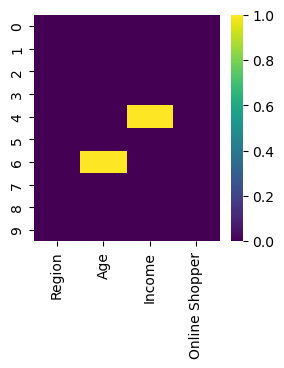

In [4]:
plt.figure(figsize=(3, 3), dpi=100)
sns.heatmap(df.isnull(), cmap="viridis")

In [5]:
df['Income'] = df['Income'].fillna(df['Income'].mean())
df['Age'] = df['Age'].fillna(df['Age'].mean())
print(df)
df.isnull().values.any()

   Region        Age        Income Online Shopper
0   India  49.000000  86400.000000             No
1  Brazil  32.000000  57600.000000            Yes
2     USA  35.000000  64800.000000             No
3  Brazil  43.000000  73200.000000             No
4     USA  45.000000  76533.333333            Yes
5   India  40.000000  69600.000000            Yes
6  Brazil  43.777778  62400.000000             No
7   India  53.000000  94800.000000            Yes
8     USA  55.000000  99600.000000             No
9   India  42.000000  80400.000000            Yes


False

## 1.2 Apply Normality tests to numerical columns and state the hypothesis clearly and comment on the normality of the data (10 points)

***
**scipy.stats.normaltest()** 

**<font color='red'>null hypothesis</font>**: x comes from a normal distribution

Reference:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

D’Agostino, R. B. (1971), “An omnibus test of normality for moderate and large sample size”, Biometrika, 58, 341-348.
***

In [6]:
def normal_test(f):
    k2, p = normaltest(f)
    alpha = 1e-3
    print("p = {:g}".format(p))
    print("")
    if p < alpha:
        print("The null hypothesis can be rejected. This is NOT a normal distribution.")
    else:
        print("The null hypothesis cannot be rejected. This is a normal distribution.")
    plt.figure(figsize=(5, 3), dpi=70)
    sns.distplot(f, kde=True)
    plt.title("")
    plt.show()

### <font color='red'>$X_{Age}$ is a normal distributed random variable</font>
See detail below

p = 0.981237

The null hypothesis cannot be rejected. This is a normal distribution.


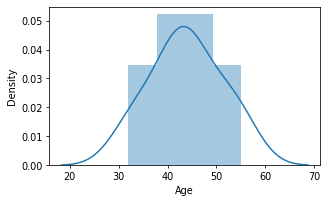

In [7]:
normal_test(df['Age'])

### <font color='red'>$X_{Income}$ <font color='red'>is a normal distributed random variable</font>
See detail below

p = 0.703061

The null hypothesis cannot be rejected. This is a normal distribution.


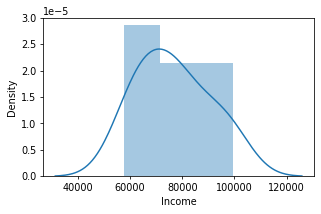

In [8]:
normal_test(df['Income'])

***
The orginal data are of integral data type. But after fill empty with np.NaN, the column data type are automatically changed into float. And in order not to take negative effect on nomality effect, NaN sample feature are filled with the mean value of the column.
***

## 1.3. Apply encodings for categorical variable and scale the features (10 points)

### 1.3.1. label encoding

In [9]:
df

,Region,Age,Income,Online Shopper
0,India,49.000000,86400.000000,No
1,Brazil,32.000000,57600.000000,Yes
2,USA,35.000000,64800.000000,No
3,Brazil,43.000000,73200.000000,No
4,USA,45.000000,76533.333333,Yes
5,India,40.000000,69600.000000,Yes
6,Brazil,43.777778,62400.000000,No
7,India,53.000000,94800.000000,Yes
8,USA,55.000000,99600.000000,No
9,India,42.000000,80400.000000,Yes


In [10]:
df['Region'] = LabelEncoder().fit_transform(df['Region'])
df['Online Shopper'] = LabelEncoder().fit_transform(df['Online Shopper'])
df

,Region,Age,Income,Online Shopper
0,1,49.000000,86400.000000,0
1,0,32.000000,57600.000000,1
2,2,35.000000,64800.000000,0
3,0,43.000000,73200.000000,0
4,2,45.000000,76533.333333,1
5,1,40.000000,69600.000000,1
6,0,43.777778,62400.000000,0
7,1,53.000000,94800.000000,1
8,2,55.000000,99600.000000,0
9,1,42.000000,80400.000000,1


### 1.3.2. scaling

In [11]:
def scaling(f, col_idx, action=None, plot=False):
    c = f.columns[col_idx]
    tmp = f[[c]]
    if action == 'log':
        tmp = np.log(tmp + 1)
        color = 'r'
    elif action == 'minmax':
        tmp = MinMaxScaler().fit_transform(tmp)
        color = 'g'
    elif action == 'standard':
        tmp = StandardScaler().fit_transform(tmp)
        color = 'b'
    else:
        color = 'k'

    if plot:
        plt.figure(figsize=(7, 2), dpi=70)
        sns.distplot(tmp, kde=True, color=color)
        plt.title("\"%s\" scaling:%s, (%.2f, %.2f)" % (c, action, tmp.min(), tmp.max()))
        plt.show()
    f[c] = tmp
    return f

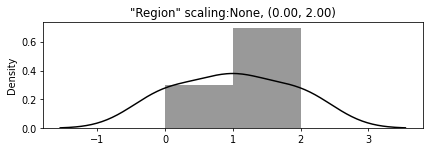

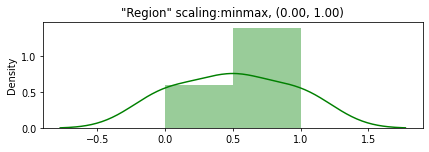

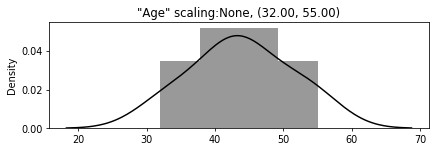

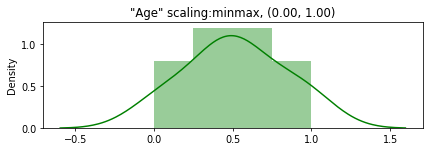

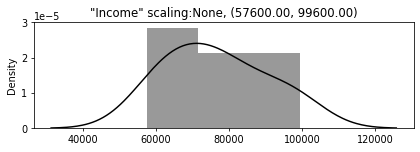

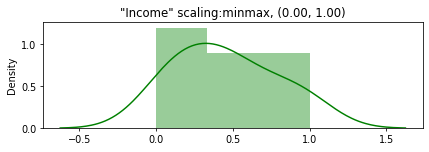

In [12]:
for i in range(3):
    df = scaling(df, i, action=None, plot=True)
    df = scaling(df, i, action='minmax', plot=True)

### data after minmax scaling

In [13]:
df

,Region,Age,Income,Online Shopper
0,0.5,0.739130,0.685714,0
1,0.0,0.000000,0.000000,1
2,1.0,0.130435,0.171429,0
3,0.0,0.478261,0.371429,0
4,1.0,0.565217,0.450794,1
5,0.5,0.347826,0.285714,1
6,0.0,0.512077,0.114286,0
7,0.5,0.913043,0.885714,1
8,1.0,1.000000,1.000000,0
9,0.5,0.434783,0.542857,1


# 2. Consider the text present in the file ‘wiki.txt’ and Answer the following questions

## 2.1. Write a program to convert following text into tokens with two tokenization methods such as ‘RegexpTokenizer()’ and ‘word_tokenize()’ from NLTK library. (Note :The tokens should not have stop words and punctuation symbols. Feel free to decide about the correct list of stop words; e.g., negative words (don’t) could be important for you. Execute both methods of tokenization along with your code of removing stop words and punctuation.) (10 points)

In [14]:
import nltk
import re
import numpy as np
import pandas as pd
from nltk.tokenize.toktok import ToktokTokenizer
from nltk import corpus, RegexpTokenizer, word_tokenize, download, ToktokTokenizer

class TextPreprocessing:
    def __init__(self):
        download('punkt')
        self.stopword_list = corpus.stopwords.words('english')
        self.stopword_list.append('nan')  # empty dataframe cell float np.nan
        self.stopword_list.append('oh')
        self.stopword_list.remove('not')

        # see: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
        self.CONTRACTION_MAP = {
            "ain't": "is not",
            "aren't": "are not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'd've": "he would have",
            "he'll": "he will",
            "he'll've": "he he will have",
            "he's": "he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how is",
            "I'd": "I would",
            "I'd've": "I would have",
            "I'll": "I will",
            "I'll've": "I will have",
            "I'm": "I am",
            "I've": "I have",
            "i'd": "i would",
            "i'd've": "i would have",
            "i'll": "i will",
            "i'll've": "i will have",
            "i'm": "i am",
            "i've": "i have",
            "isn't": "is not",
            "it'd": "it would",
            "it'd've": "it would have",
            "it'll": "it will",
            "it'll've": "it will have",
            "it's": "it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she would",
            "she'd've": "she would have",
            "she'll": "she will",
            "she'll've": "she will have",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as",
            "that'd": "that would",
            "that'd've": "that would have",
            "that's": "that is",
            "there'd": "there would",
            "there'd've": "there would have",
            "there's": "there is",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they'll've": "they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what will",
            "what'll've": "what will have",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "when's": "when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where is",
            "where've": "where have",
            "who'll": "who will",
            "who'll've": "who will have",
            "who's": "who is",
            "who've": "who have",
            "why's": "why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you would",
            "you'd've": "you would have",
            "you'll": "you will",
            "you'll've": "you will have",
            "you're": "you are",
            "you've": "you have"
        }

        self.doc = open("./data/wiki.txt", "r").readlines()
        self.test = "It's Eighty-seven NLP jobs in 1950 ~ 1960s, yet. ,  Onward!"

    def expand_match(self, contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = CONTRACTION_MAP.get(match) \
            if CONTRACTION_MAP.get(match) \
            else CONTRACTION_MAP.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    def process_contraction(self, line):
        contractions_pattern = re.compile('({})'.format('|'.join(self.CONTRACTION_MAP.keys())), flags=re.IGNORECASE | re.DOTALL)
        return contractions_pattern.sub(self.expand_match, line)


    def remove_punctuations(self, line):
        # remove punctuations
        punctuation = '\[\]\.!,;:?"\''
        return re.sub(r'[{}]+'.format(punctuation), ' ', line)


    def process_ToktokTokenizer(self, line):
        tokenizer = ToktokTokenizer()
        tokens = tokenizer.tokenize(line)
        tokens = [token.strip() for token in tokens]
        return np.array(tokens)


    def process_ToktokTokenizer(self, line):
        tokenizer = ToktokTokenizer()
        tokens = tokenizer.tokenize(line)
        tokens = [token.strip() for token in tokens]
        return np.array(tokens)


    def remove_stopwords(self, tokens):
        tks = [token for token in tokens if token not in self.stopword_list]
        sws = [token for token in tokens if token in self.stopword_list]
        return np.array(tks), np.array(sws)
    
    
if __name__ == '__main__':
    foo = TextPreprocessing()
    
    
    

[nltk_data] Downloading package punkt to /Users/francis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


***
### Preprocessing on the doc

I applied **ToktokTokenizer()** and **word_tokenizer()** on doc preprocessing
***

In [15]:
foo1 = TextPreprocessing()
tokens1 = []
stopws1 = []
for i, line in enumerate(foo1.doc):
    line = line.lower()
    line = foo1.process_contraction(line)
    line = foo1.remove_punctuations(line)
    t = foo1.process_ToktokTokenizer(line)  # ToktokTokenizer
    token, stopw = foo1.remove_stopwords(t)
    tokens1 = np.append(tokens1, token)
    stopws1 = np.append(stopws1, stopw)

foo2 = TextPreprocessing()
tokens2 = []
stopws2 = []
for i, line in enumerate(foo2.doc):
    line = line.lower()
    line = foo2.process_contraction(line)
    line = foo2.remove_punctuations(line)
    t = words = word_tokenize(line)  # word_tokenizer
    token, stopw = foo2.remove_stopwords(t)
    tokens2 = np.append(tokens2, token)
    stopws2 = np.append(stopws2, stopw)

[nltk_data] Downloading package punkt to /Users/francis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/francis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


***
After the whole process of tokenizeation, the results are equal between **tokens1** and **tokens2**
***

In [16]:
def compare_results(a1, a2):
    df1 = pd.DataFrame(pd.value_counts(a1))
    df1.rename({0: 'tokens1'}, axis='columns', inplace=True)
    df2 = pd.DataFrame(pd.value_counts(a2))
    df2.rename({0: 'tokens2'}, axis='columns', inplace=True)
    df3 = pd.concat([df1, df2], axis=1)
    df3['diff'] = df3['tokens1'] - df3['tokens2']
    return df3

print("Display the differents between tokenizers preprocessed:")
diff_df = compare_results(tokens1, tokens2)
print(diff_df.head(20))
print("Differents between tokenizers: %d" % len(diff_df[diff_df['diff'] != 0]['diff']))
print()
print("Display the differents between stopwords preprocessed:")
diff_df = compare_results(stopws1, stopws2)
print(diff_df.head(20))
print("Differents between stopwords: %d" % len(diff_df[diff_df['diff'] != 0]['diff']))


Display the differents between tokenizers preprocessed:
              tokens1  tokens2  diff
translation         5        5     0
machine             4        4     0
eliza               3        3     0
research            2        2     0
intelligence        2        2     0
developed           2        2     0
systems             2        2     0
turing              2        2     0
1966                2        2     0
restricted          2        2     0
found               2        2     0
nlp                 2        2     0
head                2        2     0
hurts               2        2     0
working             1        1     0
simulation          1        1     0
rogerian            1        1     0
vocabularies        1        1     0
worlds              1        1     0
blocks              1        1     0
Differents between tokenizers: 0

Display the differents between stopwords preprocessed:
         tokens1  tokens2  diff
the           12       12     0
in            

***
### Extra steps to analysis on removed stopwords and do some recall
***

In [17]:
# print(pd.DataFrame(pd.value_counts(stopws1)).sort_index().index)
# print(foo.doc)

***
Index(['a', 'about', 'after', 'an', 'and', 'as', 'be', 'between', 'by', 'can',
       'do', 'for', 'from', <font color='red'>'further'</font>, 'had', 'in', 'into', 'is', 'more', 'my',
       <font color='red'>'no'</font>, 'now', 'of', 'or', 'some', 'than', 'that', 'the', 'to', 'until',
       'very', 'was', 'were', 'what', 'when', 'which', 'why', 'with', 'you',
       'your'],
      dtype='object')
     
['The history of NLP generally started in the 1950s, although work can be found from earlier periods. In 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence.\n', '\n', 'The Georgetown experiment in 1954 involved fully automatic translation of more than sixty Russian sentences into English. The authors claimed that within three or five years, machine translation would be a solved problem.[2] However, real progress was much slower, and after the ALPAC report in 1966, which found that ten-year-long research had failed to fulfill the expectations, funding for machine translation was dramatically reduced. Little <font color='red'>further research</font> in machine translation was conducted until the late 1980s, when the first statistical machine translation systems were developed.\n', '\n', 'Some notably successful NLP systems developed in the 1960s were SHRDLU, a natural-language system working in restricted "blocks worlds" with restricted vocabularies, and ELIZA, a simulation of a Rogerian psychotherapist, written by Joseph Weizenbaum between 1964 and 1966. Using almost <font color='red'>no information</font> about human thought or emotion, ELIZA sometimes provided a startlingly human-like interaction. When the "patient" exceeded the very small knowledge base, ELIZA might provide a generic response, for example, responding to "My head hurts" with "Why do you say your head hurts?".']
***
***
As "<font color='red'>further research</font>" is not equal as "<font color='red'>research</font>" and "<font color='red'>no information</font>" means totally opposite to "<font color='red'>information</font>", I decide to recall "<font color='red'>further</font>" and "<font color='red'>no</font>" from stopwords_list and preprocess the doc again.
***

### Here is the result:

In [18]:
foo1 = TextPreprocessing()
tokens1 = []
stopws1 = []
for i, line in enumerate(foo1.doc):
    line = line.lower()
    line = foo1.process_contraction(line)
    line = foo1.remove_punctuations(line)
    t = foo1.process_ToktokTokenizer(line)  # ToktokTokenizer
    token, stopw = foo1.remove_stopwords(t)
    tokens1 = np.append(tokens1, token)
    stopws1 = np.append(stopws1, stopw)

print(pd.DataFrame(pd.value_counts(stopws1)).sort_index().index)

Index(['a', 'about', 'after', 'an', 'and', 'as', 'be', 'between', 'by', 'can', 'do', 'for', 'from', 'further', 'had', 'in', 'into', 'is', 'more', 'my', 'no', 'now', 'of', 'or', 'some', 'than', 'that', 'the', 'to', 'until', 'very', 'was', 'were', 'what', 'when', 'which', 'why', 'with', 'you', 'your'], dtype='object')


[nltk_data] Downloading package punkt to /Users/francis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.2. Write a regular expression to extract all the year mentions in the ‘wiki.txt’ file. (10 points)

In [19]:
import re
years = []
for i,line in enumerate(foo.doc):
    years = np.append(years, re.findall('(\d{4})', line))
years

array(['1950', '1950', '1954', '1966', '1980', '1960', '1964', '1966'],
      dtype='<U32')

# 2.3. State the differences observed in the output of tokenization methods. (10 points)

***
**`Answer:`**

It is a good way to understand different behaviors between tokenizers by observations on well designed test samples.

For the test sentence printed below, the diff between **ToktokTokenizer()** and **word_tokenizer()** are shown in the DataFrame.

Punctuation [<font color='red'>'</font>] is treated as a single token by **ToktokTokenizer()** while **word_tokenizer()** treated <font color='red'>'s</font> as a whole token. This also happened when processing <font color='red'>yet.</font>. This can be found at the end of table printed below.
***

In [20]:
print("original test sentence: \n%s"%foo.test)
print(foo.process_ToktokTokenizer(foo.test))
print(word_tokenize(foo.test))
diff_df = compare_results(foo.process_ToktokTokenizer(foo.test), word_tokenize(foo.test))
diff_df.sort_index()

original test sentence: 
It's Eighty-seven NLP jobs in 1950 ~ 1960s, yet. ,  Onward!
['It' "'" 's' 'Eighty-seven' 'NLP' 'jobs' 'in' '1950' '~' '1960s' ','
 'yet.' ',' 'Onward' '!']
['It', "'s", 'Eighty-seven', 'NLP', 'jobs', 'in', '1950', '~', '1960s', ',', 'yet', '.', ',', 'Onward', '!']


,tokens1,tokens2,diff
!,1.0,1.0,0.0
',1.0,NaN,NaN
's,NaN,1.0,NaN
",",2.0,2.0,0.0
.,NaN,1.0,NaN
1950,1.0,1.0,0.0
1960s,1.0,1.0,0.0
Eighty-seven,1.0,1.0,0.0
It,1.0,1.0,0.0
NLP,1.0,1.0,0.0


# 3. Consider this dataset from kaggle. (Download the dataset from following link : https://www.kaggle.com/dansbecker/melbourne-housing-snapshot/home) and answer the following questions :

## 3.1. Apply the feature selection techniques over the melbourne-housing -dataset namely (20 points):

∗ Correlation

∗ Chi-Square

∗ Mutual-Information

∗ Random Forest feature importance

### 3.1.0. Exploratory Data Analysis
#### 3.1.0.1. General info

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# melb_data.csv
df = pd.read_csv('./data/melb_data.csv')
print(df.columns)
dfx = df.drop('Price',axis=1)
dfy = df['Price']
df

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount'], dtype='object')


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,13580.0,2.937997e+00,0.955748,1.00000,2.000000,3.000000,3.000000e+00,1.000000e+01
Price,13580.0,1.075684e+06,639310.724296,85000.00000,650000.000000,903000.000000,1.330000e+06,9.000000e+06
Distance,13580.0,1.013778e+01,5.868725,0.00000,6.100000,9.200000,1.300000e+01,4.810000e+01
Postcode,13580.0,3.105302e+03,90.676964,3000.00000,3044.000000,3084.000000,3.148000e+03,3.977000e+03
Bedroom2,13580.0,2.914728e+00,0.965921,0.00000,2.000000,3.000000,3.000000e+00,2.000000e+01
Bathroom,13580.0,1.534242e+00,0.691712,0.00000,1.000000,1.000000,2.000000e+00,8.000000e+00
Car,13518.0,1.610075e+00,0.962634,0.00000,1.000000,2.000000,2.000000e+00,1.000000e+01
Landsize,13580.0,5.584161e+02,3990.669241,0.00000,177.000000,440.000000,6.510000e+02,4.330140e+05
BuildingArea,7130.0,1.519676e+02,541.014538,0.00000,93.000000,126.000000,1.740000e+02,4.451500e+04
YearBuilt,8205.0,1.964684e+03,37.273762,1196.00000,1940.000000,1970.000000,1.999000e+03,2.018000e+03


In [24]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount'], dtype='object')

In [25]:
df.head(5).T

,0,1,2,3,4
Suburb,Abbotsford,Abbotsford,Abbotsford,Abbotsford,Abbotsford
Address,85 Turner St,25 Bloomburg St,5 Charles St,40 Federation La,55a Park St
Rooms,2,2,3,3,4
Type,h,h,h,h,h
Price,1480000.0,1035000.0,1465000.0,850000.0,1600000.0
Method,S,S,SP,PI,VB
SellerG,Biggin,Biggin,Biggin,Biggin,Nelson
Date,3/12/2016,4/02/2016,4/03/2017,4/03/2017,4/06/2016
Distance,2.5,2.5,2.5,2.5,2.5
Postcode,3067.0,3067.0,3067.0,3067.0,3067.0


In [26]:
for _, col in enumerate(df.columns):
    print("Column Name:",col)
    print("Cagegorical display:")
    print(pd.value_counts(df[col]))
    print('-'*100)

Column Name: Suburb
Cagegorical display:
Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Sandhurst           1
Bullengarook        1
Croydon South       1
Montrose            1
Monbulk             1
Name: Suburb, Length: 314, dtype: int64
----------------------------------------------------------------------------------------------------
Column Name: Address
Cagegorical display:
36 Aberfeldie St    3
2 Bruce St          3
5 Charles St        3
53 William St       3
14 Arthur St        3
                   ..
16 Alleford St      1
2/1073 Centre Rd    1
14 Columbia St      1
21 Hardy Ct         1
6 Agnes St          1
Name: Address, Length: 13378, dtype: int64
----------------------------------------------------------------------------------------------------
Column Name: Rooms
Cagegorical display:
3     5881
2     3648
4     2688
1      681
5      596
6       67
7       10
8        8
10       1
Name: Roo

#### 3.1.0.2. label encoding

In [27]:
c = 'Suburb'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,0,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,0,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [28]:
c = 'Address'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,12794,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,0,5943,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,0,9814,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [29]:
c = 'Type'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,12794,2,0,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,0,5943,2,0,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,0,9814,3,0,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [30]:
c = 'Method'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,12794,2,0,1480000.0,1,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,0,5943,2,0,1035000.0,1,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,0,9814,3,0,1465000.0,3,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [31]:
c = 'SellerG'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,12794,2,0,1480000.0,1,23,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,0,5943,2,0,1035000.0,1,23,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,0,9814,3,0,1465000.0,3,23,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [32]:
c = 'CouncilArea'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,12794,2,0,1480000.0,1,23,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,31,-37.7996,144.9984,Northern Metropolitan,4019.0
1,0,5943,2,0,1035000.0,1,23,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,31,-37.8079,144.9934,Northern Metropolitan,4019.0
2,0,9814,3,0,1465000.0,3,23,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,31,-37.8093,144.9944,Northern Metropolitan,4019.0


In [33]:
c = 'Regionname'
f = df[c]
df[c] = LabelEncoder().fit_transform(df[c])
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,12794,2,0,1480000.0,1,23,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,31,-37.7996,144.9984,2,4019.0
1,0,5943,2,0,1035000.0,1,23,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,31,-37.8079,144.9934,2,4019.0
2,0,9814,3,0,1465000.0,3,23,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,31,-37.8093,144.9944,2,4019.0


#### 3.1.0.3. fill na

In [34]:
df.isnull().any()

Suburb           False
Address          False
Rooms            False
Type             False
Price            False
Method           False
SellerG          False
Date             False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Car               True
Landsize         False
BuildingArea      True
YearBuilt         True
CouncilArea      False
Lattitude        False
Longtitude       False
Regionname       False
Propertycount    False
dtype: bool

##### 3.1.0.3.1. fill na Column='Car'
***
Assume those sample which didn't provide Car information as 0 Cars
***

In [35]:
df['Car'].head(5)

0    1.0
1    0.0
2    0.0
3    1.0
4    2.0
Name: Car, dtype: float64

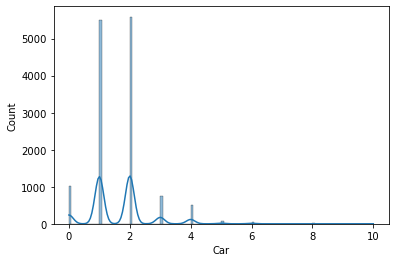

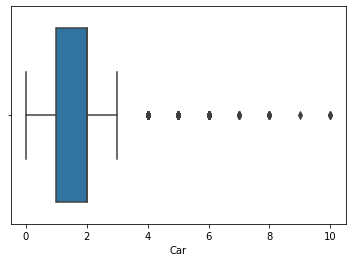

In [36]:
# The distribution, Agglomeration and Outliers
sns.histplot(df['Car'], kde=True)
plt.show()
sns.boxplot(x=df['Car'])
plt.show()

In [37]:
# 62 Nan Cars
print("%d/%d empty Car"%(df['Car'][df['Car'].isna()].size, df['Car'].size))

62/13580 empty Car


In [38]:
# assume those sample which didn't provide Car information as 0 Cars.
df['Car'] = df['Car'].fillna(0)
print("%d/%d empty Car"%(df['Car'][df['Car'].isna()].size, df['Car'].size))

0/13580 empty Car


##### 3.1.0.3.2. fill na Column='BuildingArea'
***
Conclusion:

The sns.regplot() shows there is no easy linear relationship between 'BuildingArea' and 'Price', so the Area cann't be easily refilled with any reasonable value instead. Besides, 'BuildingArea' is so important to describe the sale price of house, null value of BuildingArea is not acceptable. 

With a scale of 6450/13580 empty BuildingArea in this feature, rows with nan 'BuildingArea' value will be dropped out by data clean in future steps.
***

In [39]:
df['BuildingArea'].head(5)

0      NaN
1     79.0
2    150.0
3      NaN
4    142.0
Name: BuildingArea, dtype: float64

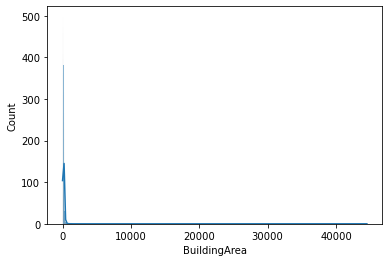

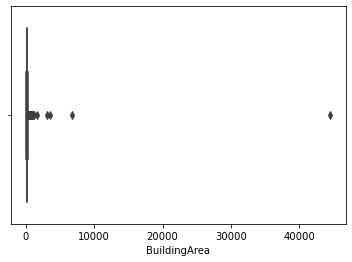

In [40]:
# The distribution, Agglomeration and Outliers
sns.histplot(df['BuildingArea'], kde=True)
plt.show()
sns.boxplot(x=df['BuildingArea'])
plt.show()

In [41]:
df['BuildingArea'].sort_values(ascending=False)

13245    44515.0
1484      6791.0
2560      3558.0
1588      3112.0
2234      1561.0
          ...   
13569        NaN
13570        NaN
13574        NaN
13575        NaN
13577        NaN
Name: BuildingArea, Length: 13580, dtype: float64

BuildingArea      44515.0
Price           1355000.0
Name: 13245, dtype: object


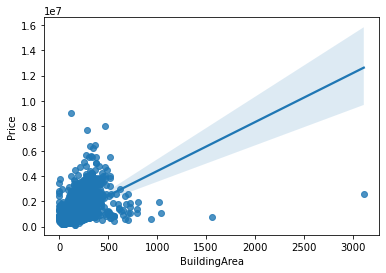

In [42]:
print(df.loc[13245,][['BuildingArea', 'Price']])
sns.regplot(x="BuildingArea", y="Price", data=df.dropna());

In [43]:
# 6450 Nan BuildingArea
print("%d/%d empty BuildingArea"%(df['BuildingArea'][df['BuildingArea'].isna()].size, df['BuildingArea'].size))

6450/13580 empty BuildingArea


##### 3.1.0.3.3. fill na Column='YearBuilt'
***

| year build | Building Area | nan count
| :- | - | :-:
| True | True | 5103
| True | False | 272
| False | True | 1347
| False | False | 6858
| Total | | 13580

Based on the analysis in these two sectors, I decided to remove rows with Nan values on these two columns
***

In [44]:
df['YearBuilt'].head(5)

0       NaN
1    1900.0
2    1900.0
3       NaN
4    2014.0
Name: YearBuilt, dtype: float64

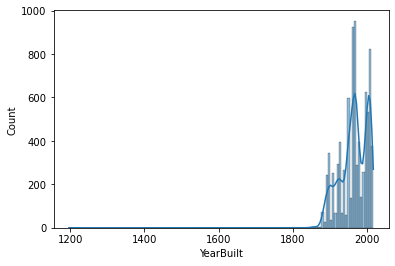

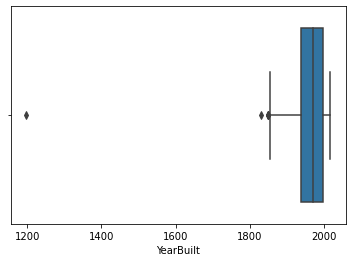

In [45]:
# The distribution, Agglomeration and Outliers
sns.histplot(df['YearBuilt'], kde=True)
plt.show()
sns.boxplot(x=df['YearBuilt'])
plt.show()

In [46]:
# 5375 Nan BuildingArea
print("%d/%d empty YearBuilt"%(df['YearBuilt'][df['YearBuilt'].isna()].size, df['YearBuilt'].size))

5375/13580 empty YearBuilt


In [47]:
mask = df[['BuildingArea','YearBuilt']].isna()
print(mask.shape)
print(mask[mask['BuildingArea']==True].shape)
print(mask[mask['YearBuilt']==True].shape)
print(mask[(mask['YearBuilt']==True) & (mask['BuildingArea']==True)].shape)
print(mask[(mask['YearBuilt']==True) | (mask['BuildingArea']==True)].shape)

(13580, 2)
(6450, 2)
(5375, 2)
(5103, 2)
(6722, 2)


#### 3.1.0.4. deal with DateTime

In [48]:
df['sale_year'] = pd.to_datetime(df["Date"]).apply(lambda x: x.year)
df['sale_month'] = pd.to_datetime(df["Date"]).apply(lambda x: x.month)
df['sale_day'] = pd.to_datetime(df["Date"]).apply(lambda x: x.day)
df['sale_week'] = pd.to_datetime(df["Date"]).apply(lambda x: x.week)
df = df.drop('Date',axis=1)
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,sale_year,sale_month,sale_day,sale_week
0,0,12794,2,0,1480000.0,1,23,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,31,-37.79960,144.99840,2,4019.0,2016,3,12,10
1,0,5943,2,0,1035000.0,1,23,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,31,-37.80790,144.99340,2,4019.0,2016,4,2,13
2,0,9814,3,0,1465000.0,3,23,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,31,-37.80930,144.99440,2,4019.0,2017,4,3,14
3,0,9004,3,0,850000.0,0,23,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,31,-37.79690,144.99690,2,4019.0,2017,4,3,14
4,0,10589,4,0,1600000.0,4,155,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,31,-37.80720,144.99410,2,4019.0,2016,4,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,302,1991,4,0,1245000.0,1,16,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,33,-37.90562,145.16761,4,7392.0,2017,8,26,34
13576,305,12234,3,0,1031000.0,3,251,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,33,-37.85927,144.87904,6,6380.0,2017,8,26,34
13577,305,12745,3,0,1170000.0,1,194,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,33,-37.85274,144.88738,6,6380.0,2017,8,26,34
13578,305,13311,4,0,2500000.0,0,222,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,33,-37.85908,144.89299,6,6380.0,2017,8,26,34


#### 3.1.0.5. scaling

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression, VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler


class Q3:
    def __init__(self):
        # melb_data.csv
        self.df = pd.read_csv('./data/melb_data.csv')

    def __label_encoding(self, c):
        self.df[c] = LabelEncoder().fit_transform(self.df[c])

    def label_encoding(self):
        self.__label_encoding('Suburb')
        self.__label_encoding('Address')
        self.__label_encoding('Type')
        self.__label_encoding('Method')
        self.__label_encoding('SellerG')
        self.__label_encoding('CouncilArea')
        self.__label_encoding('Regionname')

    def handle_nan(self):
        self.df['Car'] = self.df['Car'].fillna(0)
        self.df = self.df.dropna()

    def extract_date(self):
        self.df['sale_year'] = pd.to_datetime(self.df["Date"]).apply(lambda x: x.year)
        self.df['sale_month'] = pd.to_datetime(self.df["Date"]).apply(lambda x: x.month)
        self.df['sale_day'] = pd.to_datetime(self.df["Date"]).apply(lambda x: x.day)
        self.df['sale_week'] = pd.to_datetime(self.df["Date"]).apply(lambda x: x.week)
        self.df = self.df.drop('Date', axis=1)

    def scaling(self, f, c, action=None, plot=False):
        tmp = f[[c]]
        if action == 'log':
            tmp = np.log(tmp + 1)
            color = 'r'
        elif action == 'minmax':
            tmp = MinMaxScaler().fit_transform(tmp)
            color = 'g'
        elif action == 'standard':
            tmp = StandardScaler().fit_transform(tmp)
            color = 'b'
        else:
            color = 'k'

        if plot:
            plt.figure(figsize=(7, 2), dpi=70)
            sns.histplot(tmp, kde=True, color=color)
            plt.title("\"%s\" scaling:%s, (%.2f, %.2f)" % (c, action, tmp.min(), tmp.max()))
            plt.show()
        f[c] = tmp
        return f

    def chi_square_test(self, X, y, printed=False):
        skb = SelectKBest(chi2, k=len(X.columns))
        skb.fit(X.to_numpy(), y.to_numpy())
        return self.feature_importance_report(X, skb.scores_, printed)

    def variance_threshold(self, X, printed=False):
        selector = VarianceThreshold()
        selector.fit(X)
        return self.feature_importance_report(X, selector.variances_, printed)

    def mutual_information_classification(self, X, y, printed=False):
        mi_score = mutual_info_classif(X.to_numpy(), y.to_numpy())
        return self.feature_importance_report(X, mi_score, printed)

    def mutual_information_regression(self, X, y, printed=False):
        mi_score = mutual_info_regression(X.to_numpy(), y.to_numpy())
        return self.feature_importance_report(X, mi_score, printed)

    def random_forest_feature_importance(self, X, y):
        clf = RandomForestRegressor(n_estimators=50)
        clf.fit(X, y)
        return self.feature_importance_report(X, clf.feature_importances_)

    def feature_importance_report(self, X, scores, printed=False):
        scores_df = pd.DataFrame(X.columns, columns=['name'])
        scores_df['scores'] = scores
        scores_df = scores_df.sort_values(['scores'], ascending=False).reset_index(drop=True, inplace=False)
        if printed:
            print("%25s\t%15s" % ('colume', 'score'))
            for i, col in enumerate(scores_df['name']):
                print("%25s\t%15s" % (col, "%.3f" % scores_df['scores'][i]))
        return scores_df

    def feature_importance_compare_visualization(self):
        df_chi2 = self.chi_square_test(dfx, dfy)
        df_chi2 = self.scaling(df_chi2, 'scores', action='minmax', plot=False)
        df_chi2['selector'] = 'chi_square'
        df_mir = self.mutual_information_regression(dfx, dfy)
        df_mir = self.scaling(df_mir, 'scores', action='minmax', plot=False)
        df_mir['selector'] = 'mutual information'
        df_rf = self.random_forest_feature_importance(dfx, dfy)
        df_rf = self.scaling(df_rf, 'scores', action='minmax', plot=False)
        df_rf['selector'] = 'Random Forest feature importance'
        df_feature_important_report = pd.concat([df_mir, df_rf, df_chi2], axis=0)
        sns.set(rc={'figure.figsize': (20, 10)})
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=45)
        sns.barplot(data=df_feature_important_report, x="name", y="scores", hue="selector")
        plt.show()

    def heatmap(self, X):
        plt.figure(figsize=(10, 8), dpi=80)
        corr = X.corr()
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr, mask=mask, cmap="viridis")


if __name__ == '__main__':
    foo = Q3()
    foo.label_encoding()
    foo.handle_nan()
    foo.extract_date()
    
    dfx = foo.df.drop('Price', axis=1)
    for _, c in enumerate(dfx.columns):
        dfx = foo.scaling(dfx, c, action='minmax', plot=False)

#     foo.scaling(foo.df, 'Price', action='log', plot=False)
#     foo.scaling(foo.df, 'Price', action='minmax', plot=False)
    dfy = foo.df['Price']
    pass


In [50]:
dfx

,Suburb,Address,Rooms,Type,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,sale_year,sale_month,sale_day,sale_week
1,0.000000,0.444262,0.142857,0.0,0.25,0.086142,0.052743,0.068577,0.222222,0.000000,0.0,0.004216,0.025386,0.856448,0.939394,0.472005,0.458373,0.285714,0.170735,0.0,0.272727,0.000000,0.250000
2,0.000000,0.733682,0.285714,0.0,0.75,0.086142,0.052743,0.068577,0.333333,0.142857,0.0,0.003622,0.048201,0.856448,0.939394,0.470154,0.459389,0.285714,0.170735,1.0,0.272727,0.035714,0.270833
4,0.000000,0.791626,0.428571,0.0,1.00,0.580524,0.052743,0.068577,0.333333,0.000000,0.2,0.003243,0.045630,0.995134,0.939394,0.472931,0.459085,0.285714,0.170735,0.0,0.272727,0.142857,0.270833
6,0.000000,0.160075,0.285714,0.0,0.25,0.580524,0.052743,0.068577,0.444444,0.142857,0.0,0.006622,0.067481,0.868613,0.939394,0.479277,0.464369,0.285714,0.170735,0.0,0.545455,0.107143,0.541667
7,0.000000,0.996935,0.142857,0.0,0.25,0.580524,0.052743,0.068577,0.222222,0.000000,0.2,0.006919,0.034383,0.844282,0.939394,0.474517,0.460406,0.285714,0.170735,0.0,0.636364,0.285714,0.645833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13572,0.945687,0.912075,0.142857,0.0,0.00,0.569288,0.305907,0.089048,0.222222,0.000000,0.1,0.005676,0.025386,0.985401,1.000000,0.605970,0.545143,0.285714,0.091247,1.0,0.636364,0.857143,0.687500
13573,0.952077,0.742953,0.428571,0.0,0.25,0.973783,0.310127,0.030706,0.444444,0.142857,0.1,0.017892,0.055270,0.953771,1.000000,0.359140,0.107238,0.857143,0.742063,1.0,0.636364,0.857143,0.687500
13576,0.974441,0.914617,0.285714,0.0,0.75,0.940075,0.143460,0.016377,0.333333,0.142857,0.2,0.009000,0.042738,0.972019,1.000000,0.404090,0.342151,0.857143,0.281784,1.0,0.636364,0.857143,0.687500
13578,0.974441,0.995140,0.428571,0.0,0.00,0.831461,0.143460,0.016377,0.444444,0.000000,0.5,0.023405,0.050450,0.880779,1.000000,0.404342,0.356328,0.857143,0.281784,1.0,0.636364,0.857143,0.687500


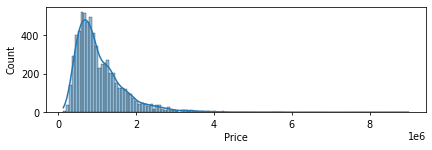

In [51]:
plt.figure(figsize=(7, 2), dpi=70)
sns.histplot(dfy, kde=True)
plt.show()

### 3.1.1. Correlation

***
***After some simple Feature Engineering, now I'm going to apply the dataset on some feature selection methods.***
***

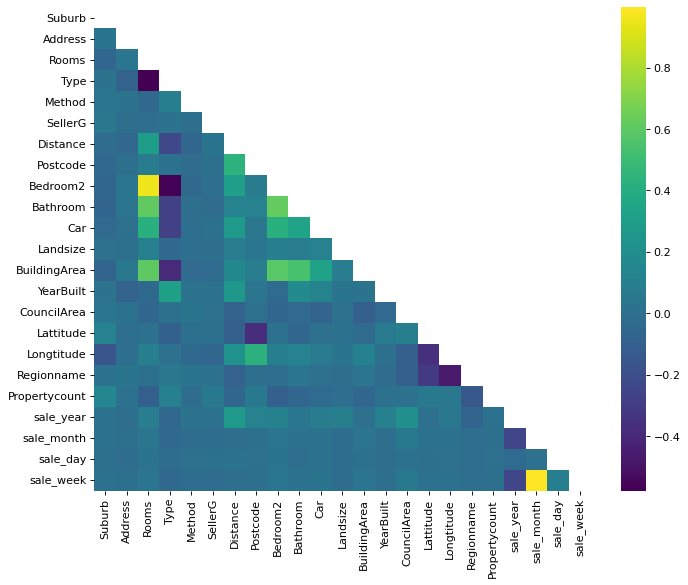

In [52]:
foo.heatmap(dfx)

In [53]:
dfx[['sale_month', 'sale_week']].corr()

,sale_month,sale_week
sale_month,1.000000,0.996169
sale_week,0.996169,1.000000


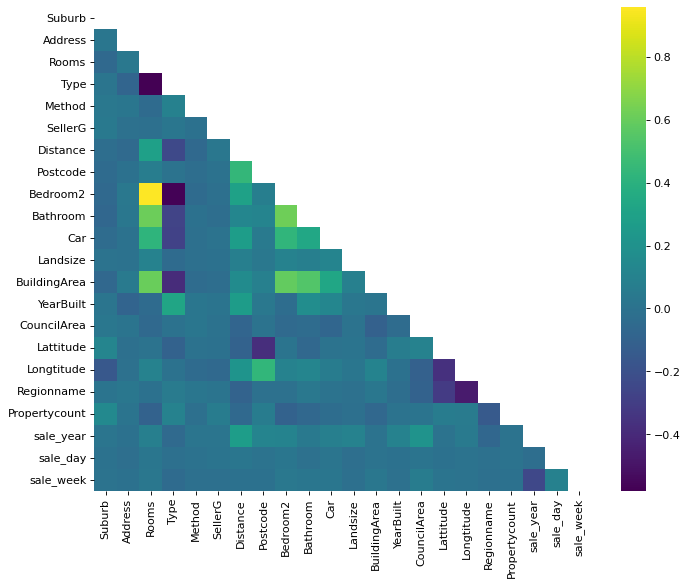

In [54]:
dfx_drop = dfx.drop(['sale_month'], axis=1)
foo.heatmap(dfx_drop)

In [55]:
dfx_drop[['Rooms', 'Bedroom2']].corr()

,Rooms,Bedroom2
Rooms,1.000000,0.955959
Bedroom2,0.955959,1.000000


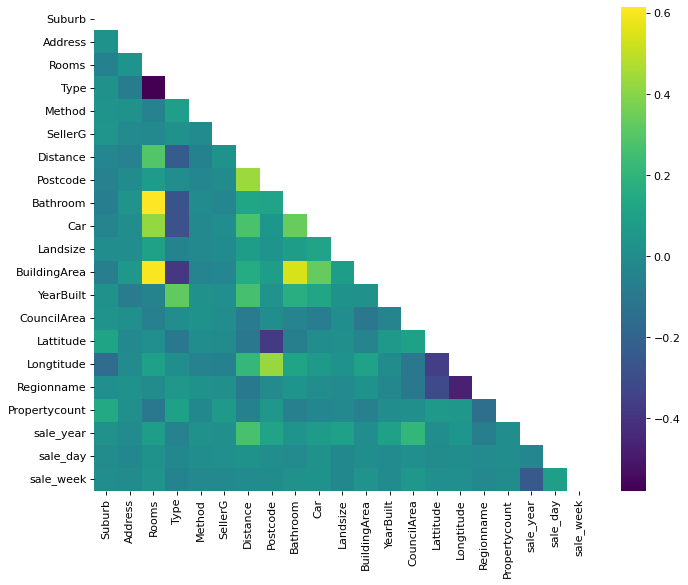

In [56]:
dfx_drop = dfx_drop.drop(['Bedroom2'], axis=1)
foo.heatmap(dfx_drop)

***
After applying correlation coefficient metric. dfx_drop should be applied.
***

### 3.1.2. Chi-Square

In [57]:
df_chi2 = foo.chi_square_test(dfx, dfy)
df_chi2 = foo.scaling(df_chi2, 'scores', action='minmax', plot=False)
df_chi2['selector'] = 'chi_square'

### 3.1.3. Mutual-Information

In [58]:
df_mir = foo.mutual_information_regression(dfx, dfy)
df_mir = foo.scaling(df_mir, 'scores', action='minmax', plot=False)
df_mir['selector'] = 'mutual information regression'

### 3.1.4. Random Forest feature importance

In [59]:
df_rf = foo.random_forest_feature_importance(dfx, dfy)
df_rf = foo.scaling(df_rf, 'scores', action='minmax', plot=False)
df_rf['selector'] = 'Random Forest feature importance'

### 3.1.5. df_var

In [60]:
df_var = foo.variance_threshold(dfx)
df_var = foo.scaling(df_var, 'scores', action='minmax', plot=False)
df_var['selector'] = 'variance threshold'

## 3.2. Compare the importance of selected features using bar chart (10 points).

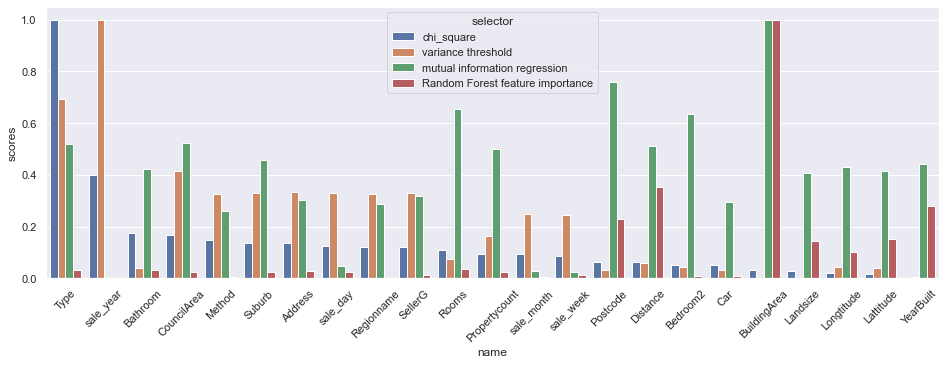

In [61]:
df_feature_important_report = pd.concat([df_chi2, df_var, df_mir, df_rf], axis=0)
sns.set(rc={'figure.figsize':(16, 5)})
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
sns.barplot(data=df_feature_important_report, x="name", y="scores", hue="selector")
plt.show()

## 3.3. Comment on the results obtained from various feature selection techniques and which is the best and worst feature selection selection technique on the given dataset (10 points).

***

**`Answer:`**

Chi-Square is more reasonable to apply on this dataset compares to the other feature selectors.

Random Froest is the worst feature selector on this dataset because of it has feal

***